# Solar Active Regions

In this example, a dataset containing different solar properties are analysed. The goal is to forecast the flux (first column) with the help of previous measurements of the other features. The dataset is significantly harder than the artificially created 'toy_dataset_sine' dataset. However, it is believed to contain more signal than stock market time series, therefore serving as a nice intermediate. The focuss in this example will be on column selection for the different SCINets in the stack and comparing performance with other prediction models. 

As always, we will begin by importing the neccessary libraries:

In [1]:
import os
import sys
import numpy as np

from tqdm import tqdm

cwd = os.getcwd()
BASE_DIR = os.path.dirname(os.path.dirname(cwd))

sys.path.insert(0, BASE_DIR)

### Importing and Visualizing the raw data

Since the data is too large to be stored on Github, the data for this example has to be separately downloaded, which can be done here: insert link!. It should then be placed under datasets in the SAR folder with names 'SAR_train.npy' and 'SAR_test.npy'. Only then can the data be loaded in: 

In [2]:
data_train = np.load(BASE_DIR + '/datasets/SAR/SAR_train.npy')
data_test = np.load(BASE_DIR + '/datasets/SAR/SAR_test.npy')

print('Number of features: {}'.format(data_train.shape[2]))
print('Number of training samples: {}'.format(data_train.shape[0]))
print('Number of test samples: {}'.format(data_test.shape[0]))
print('Length of each sample: {}'.format(data_test.shape[1]))


Number of features: 16
Number of training samples: 23951
Number of test samples: 10670
Length of each sample: 200


Immediatly, to prevent any data leakage from the labels to the data, the samples are split into a data and label component:

In [3]:
X_len = 168
Y_len = 32

X_train = data_train[:,:X_len,:]
y_train = data_train[:,X_len:X_len+Y_len,:]
X_val = data_test[:data_test.shape[0]//2,:X_len,:]
y_val = data_test[:data_test.shape[0]//2,X_len:X_len+Y_len,:]
X_test = data_test[data_test.shape[0]//2:,:X_len,:]
y_test = data_test[data_test.shape[0]//2:,X_len:X_len+Y_len,:]

The first thing we will do is plot histograms of the distributions of the different features. This gives us a good initial feel for the data:

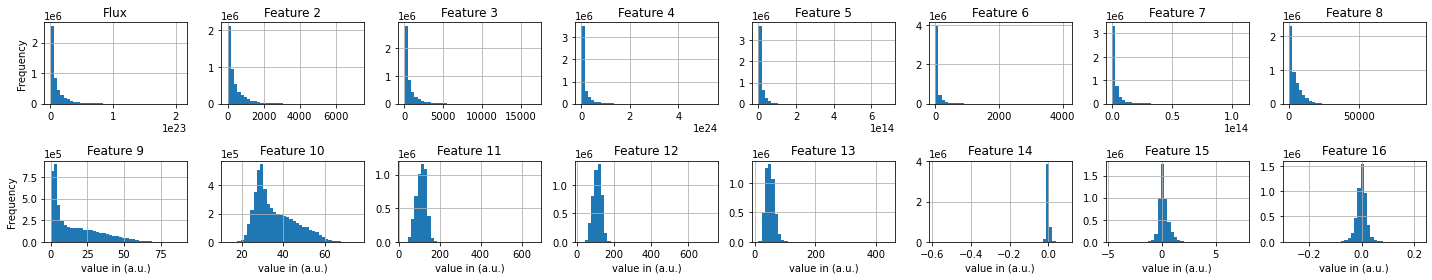

In [4]:
from utils.plotting import plot_histograms

ncols = data_train.shape[2]//2

plot_histograms(ncols, data_train)



Besides observing that the features vary wildly in order of magnitude (and should therefore certainly be standardized), we also remark that a lot of the distributions, especially those of the upper row are heavily skewed to the left. As such, before training, applying a logarithmic function to counteract this is required.

In addition, the number of features we have is quite high for multivariate time series analysis. As such, it is interesting to know which are correlated most with the flux such that we can prioritize these. As such, the mean pearson correlation coefficient between the first and consequent columns is computed. Of course, this does not take into account non-linear interactions but hopefully it grants us a rough estimate:

100%|██████████| 16/16 [00:32<00:00,  2.03s/it]


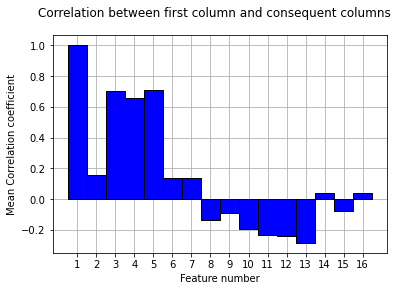

In [5]:
from scipy.stats import pearsonr

from utils.plotting import barplot_correlations

mean_correlations = []

for i in tqdm(range(X_train.shape[2])):
    correlations = []

    for j in range(X_train.shape[0]):
        correlations.append(pearsonr(X_train[j,:,0],X_train[j,:,i])[0])

    mean_correlations.append(np.mean(correlations))

barplot_correlations(X_train.shape[2], mean_correlations)

There are strong positive correlations between features 3,4,5 and feature 1 (of course the correlation with itself is 1). In addition, features 11,12 and 13 show some negative correlation with the flux. As such, we will remark these columns as being more promising than the others.

### Preprocessing the data

Because the data is already divided into samples, the data only has to be normalized. As previously mentioned, we also apply a log-function to deal with skewed data. Fortunately, all of this can be handled by the standardize function from the 'preprocessing_data.py' from the base:

In [6]:
from base.preprocess_data import standardize

standardization_settings = {
                    'per_sample': False,
                    'leaky': False,
                    'mode': 'log', #only if per sample is false, choose from log, sqrt or lin
                    'sqrt_val': 2, #of course only if mode is sqrt
}

X_train_proc, y_train_proc, X_val_proc, y_val_proc, X_test_proc, y_test_proc, mean, std = \
    standardize(standardization_settings, [[X_train,y_train],[X_val, y_val],[X_test,y_test]], X_len, Y_len) 

### Training

Next we can go ahead and train SCINet on our data. This we will do for 20 epochs using two stacked SCINets for different columns selections. The columnn selections are based on our correlation observations. That is, the different runs include sequentially less important features, at least according to that metric. Although the code required to train SCINet is provided, it is quite resource-intensive, especially without GPU access. As such, it is advised to load the weights that are stored in the 'saved_weights' folder, the option for which is also provided.


In [7]:
from base.SCINet import scinet_builder
from base.train_scinet import train_scinet

n_epochs = 20
n_features = 16

columns_list = [[0],[0,2,3,4],[0,2,3,4,10,11,12],np.arange(n_features)]
columns_string = ['0','0,2,3,4','0,2,3,4,10,11,12','all_columns']
models = []

use_pretrained_models = True
if use_pretrained_models:
    for i,columns in enumerate(columns_list):
        model = scinet_builder(
                    output_len=  [Y_len,Y_len],
                    input_len = X_len,
                    output_dim = [len(columns), 1],
                    input_dim = len(columns),
                    selected_columns = [np.arange(len(columns)),[0]], 
                    loss_weights = [0.3,0.7],
                    hid_size = 128,
                    num_levels = 2,
                    kernel = 5,
                    dropout = 0.5,
                    learning_rate = 0.001,)
        model.load_weights('saved_weights/{}.h5'.format(columns_string[i]))
        models.append(model)

else:
    for i, columns in enumerate(columns_list):
        results = train_scinet(
                    X_train= X_train_proc[:,:,columns],
                    y_train= y_train_proc[:,:,columns],
                    X_val= X_val_proc[:,:,columns],
                    y_val= y_val_proc[:,:,columns],
                    X_test= X_test_proc[:,:,columns],
                    y_test= y_test_proc[:,:,columns],
                    epochs = n_epochs,
                    batch_size = 128,
                    X_LEN = X_len,
                    Y_LEN = [Y_len,Y_len],
                    output_dim = [len(columns), 1],
                    selected_columns = [np.arange(len(columns)),[0]],
                    hid_size= 128,
                    num_levels= 2,
                    kernel = 5,
                    dropout = 0.3,
                    loss_weights= [0.3,0.7],
                    learning_rate = 0.001,
                    probabilistic = False,
                    )
        models.append(results[0])

### Analysing results

To gain an intuition on the strength of our performance, let us begin by plotting some of the predictions made by the network. In order to do this, we still have to calculate these predictions. Once again, this can be time-consuming without access to a GPU (~5min). For that reason, they can also be imported from the predictions folder. 

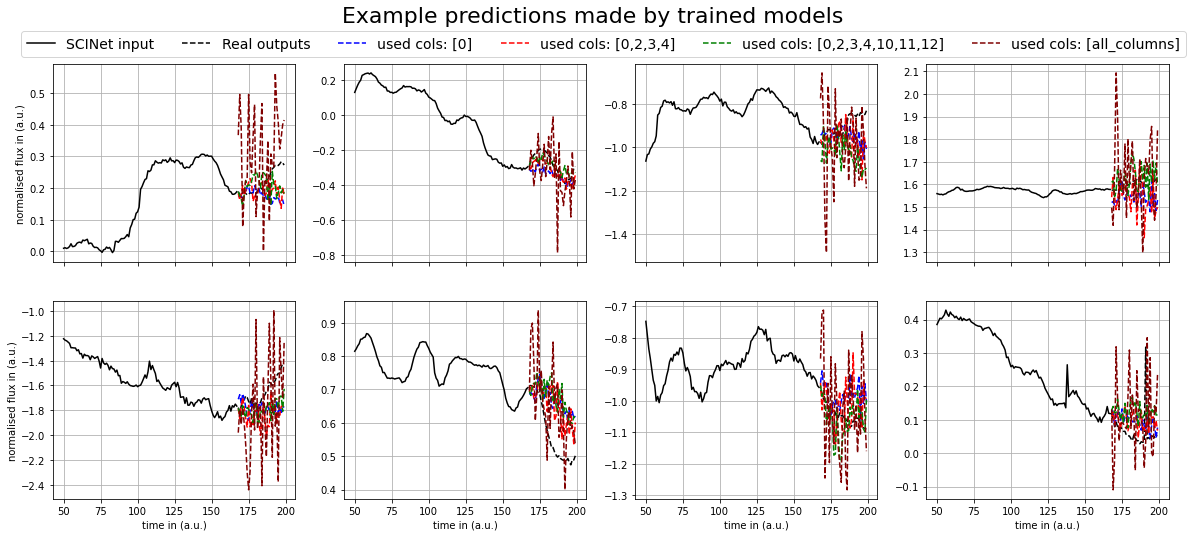

In [8]:
from utils.plotting import plot_model_predictions

N_columns = 4
N_rows = 2

samples = np.random.randint(0,X_test_proc.shape[0], size = N_columns * N_rows)
predictions = []

use_precalculated_predictions = True
if use_precalculated_predictions:

    for columns in columns_string:
        predictions.append(np.load('predictions/prediction_{}.npy'.format(columns)))

else:
    print('making predictions... (takes ~5min)')
    for i,model in enumerate(models):
        predictions.append(model.predict(X_test_proc[:,:,columns_list[i]])[1])
        print('made prediction for model {}/{}'.format(i+1,len(models)))

plot_model_predictions(X_test_proc,y_test_proc,predictions,samples,\
    N_rows,N_columns,X_len,Y_len, columns_string)

Most notably, we observe that when using all the columns the predictions are very unstable. The reason for this can likely be found in the fact that the SCINet model used to train it contains 14 million parameters, making it hard to train and prone to overfitting. To take a more systematic look at the strength of the predictions, we will plot the per-timestep mean absolute error. That is, for each model we calculate the mae at all of the prediction steps. In addition, the per-timestep mean absolute error for a model always predicting the last value X_test is included as a benchmark.

c:\Users\PimVeefkind\miniconda3\envs\learn\lib\site-packages\IPython\core\interactiveshell.py:3337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


Overall mean absolute error constant model = 0.06373161098314963
Overall mean absolute error model with columns 0 = 0.06676401361160628
Overall mean absolute error model with columns 0,2,3,4 = 0.068618969930949
Overall mean absolute error model with columns 0,2,3,4,10,11,12 = 0.06336633768669013
Overall mean absolute error model with columns all_columns = 0.15324762073992865


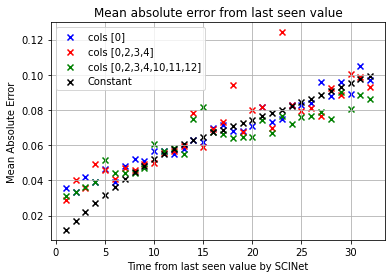

In [9]:
from sklearn.metrics import mean_absolute_error as mae

from utils.plotting import plot_per_timestep_mae

constant_predictions = np.stack((X_test_proc[:,-1, 0] for _ in range(Y_len)),axis = 1)

print('Overall mean absolute error constant model = ' + \
    str(mae(y_test_proc[:,:,0],constant_predictions)))

for i,prediction in enumerate(predictions):
    print('Overall mean absolute error model with columns {} = '.format(columns_string[i]) + \
    str(mae(y_test_proc[:,:,0],prediction[:,:,0])))

plot_per_timestep_mae(y_test_proc,predictions[:-1], constant_predictions, Y_len, columns_string)



Apart from using all columns, which therefore has not been incorperated in the plot, performance between the different SCINet is comparable. In fact, performances of the different models are not only comparable with each other but also with the naive constant implementation. The difference being that the SCINet models start to outperform the constant model predicting points that lie further in the future.

One reason that we are not outperforming the constant implementation is that the time series samples used are not particularly lengthy (only 200 timesteps), where SCINet excels at also encapturing long term trends and seasonality. With the current format of the data however there is no way to investigate this hypothesis with this data (The notebooks regarding cryptodata deal with longer series and it is investigated there). 

All in all, we have shown how to use SCINet on a real dataset and investigated the influence of selecting columns before training SCINet. Here, we can conclude that more columns is not necessarily better. The reason being that if columns do not add information, they only introduce additional parameters. In the best case, this unneccessarily complicates training as more parameters have to be fitted. In the worst case however, this leads to serious overfitting. 